In [1]:

import numpy as np

print(np.__version__)


2.0.2


In [2]:
# import required packages
import time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.integrate import odeint

# import MAGI-X packages
from scripts.magix.dynamic import nnSTModule, nnMTModule # neural network module
from scripts.magix.inference import FMAGI # inferred module

### LV

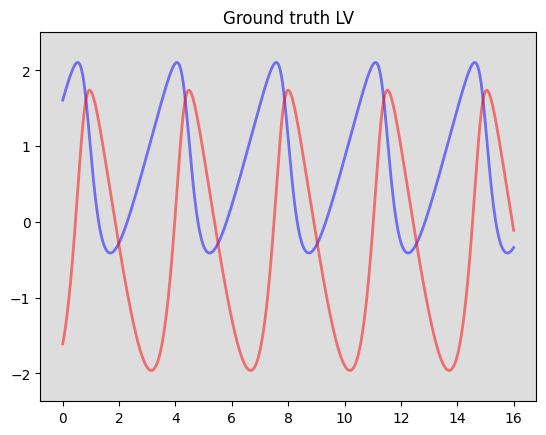

In [6]:
# define FitzHugh-Nagumo model dynamic
def LV(y, t, a, b, c, d):
	P, D = y # Prey, Predator
	dPdt = a * P - b * P * D
	dDdt = c * P * D - d * D
	return (dPdt,dDdt)
# model parameters
a, b, c, d = 1.5, 1, 1, 3
# initial condition
P0, D0 = 5, 0.2 
y0 = P0, D0
# time point for evaluation
tdata = np.linspace(0, 16, 1281)
# integration
xdata = odeint(LV, y0, tdata, args = (a,b,c,d))
xdata = np.log(xdata)


# visualization
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(tdata, xdata[:,0], 'b', alpha=0.5, lw=2, label='V')
ax.plot(tdata, xdata[:,1], 'r', alpha=0.5, lw=2, label='R')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Ground truth LV')
plt.show()

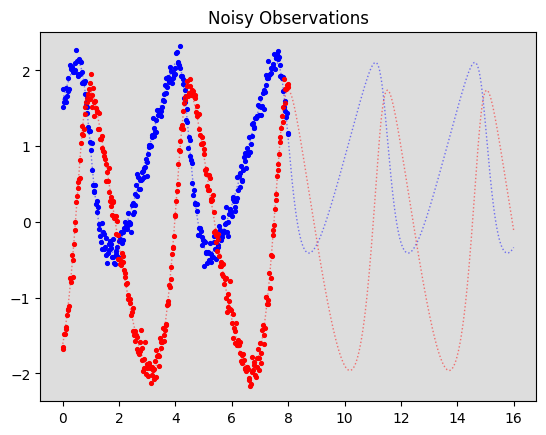

In [4]:
# setting
seed = 188714368 # random seed
noise = [0.1,0.1] # noise level
no_train = 321 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [5]:
# MAP Inference - Multi-task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnMTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

/mnt/home/sykim/.conda/envs/py39/lib/python3.9/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /opt/conda/conda-bld/pytorch_1729647380992/work/torch/csrc/utils/tensor_new.cpp:651.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


1/1000 iteration: 20.136816
200/1000 iteration: 5.755820
400/1000 iteration: 2.705956
600/1000 iteration: 1.755919
800/1000 iteration: 1.432934
1000/1000 iteration: 1.305385
run time: 11.76 seconds


In [ ]:
# setting
seed = 188714368 # random seed
noise = [0.1,0.1] # noise level
no_train = 41 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [ ]:
# MAP Inference - Multi-task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnMTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

In [ ]:
# reconstruction with ode numerical integration from x0
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

In [ ]:
# inferred + forecast with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
tpred = trecon[trecon >= np.max(tinfer)]
tr, xr = model.predict(tpred,tinfer,xinfer,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Inferred + Forecast Trajectory')
plt.show()

In [ ]:
# Add functions for vector field visualization
def compute_true_vector_field(grid_size=20, x_range=(0, 10), y_range=(0, 10)):
    """Compute the true vector field for the Lotka-Volterra model"""
    x = np.linspace(x_range[0], x_range[1], grid_size)
    y = np.linspace(y_range[0], y_range[1], grid_size)
    X, Y = np.meshgrid(x, y)
    U, V = np.zeros_like(X), np.zeros_like(Y)
    for i in range(grid_size):
        for j in range(grid_size):
            derivs = LV([X[i, j], Y[i, j]], 0, a, b, c, d)
            U[i, j], V[i, j] = derivs[0], derivs[1]
    return {'X': X, 'Y': Y, 'U': U, 'V': V, 'magnitude': np.sqrt(U**2 + V**2)}

def compute_vector_field(model, grid_size=20, x_range=(0, 10), y_range=(0, 10)):
    """Compute the vector field for a neural network model"""
    x = np.linspace(x_range[0], x_range[1], grid_size)
    y = np.linspace(y_range[0], y_range[1], grid_size)
    X, Y = np.meshgrid(x, y)
    U, V = np.zeros_like(X), np.zeros_like(Y)
    for i in range(grid_size):
        for j in range(grid_size):
            state = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float64)
            with torch.no_grad():
                d = model(state).numpy()
            U[i, j], V[i, j] = d[0, 0], d[0, 1]
    return {'X': X, 'Y': Y, 'U': U, 'V': V, 'magnitude': np.sqrt(U**2 + V**2)}

def compute_estimated_nullclines(model, resolution=200, x_range=(0, 10), y_range=(0, 10)):
    """Compute the estimated nullclines for a neural network model"""
    x = np.linspace(x_range[0], x_range[1], resolution)
    y = np.linspace(y_range[0], y_range[1], resolution)
    X, Y = np.meshgrid(x, y)
    U, V = np.zeros_like(X), np.zeros_like(Y)
    for i in range(resolution):
        for j in range(resolution):
            state = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float64)
            with torch.no_grad():
                d = model(state).numpy()
            U[i, j], V[i, j] = d[0, 0], d[0, 1]
    return {'X': X, 'Y': Y, 'U': U, 'V': V}

def sample_training_data_for_visualization(states, max_points=1000):
    """Sample data points for visualization"""
    if states.shape[0] <= max_points:
        return states
    indices = np.linspace(0, states.shape[0]-1, max_points, dtype=int)
    return states[indices]

def plot_vector_field_comparison(true_vf, single_vf, multi_vf, single_model, multi_model, 
                                single_states, multi_states, filename="vector_field_comparison.png"):
    """Create a three-panel comparison of vector fields"""
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Calculate true nullclines for LV model
    x_range = np.linspace(0, 10, 1000)
    y_range = np.linspace(0, 10, 1000)
    
    # X-nullcline is where dX/dt = 0 => a*X - b*X*Y = 0 => Y = a/b (when X ≠ 0)
    # Y-nullcline is where dY/dt = 0 => c*X*Y - d*Y = 0 => X = d/c (when Y ≠ 0)
    x_null_y = np.ones_like(x_range) * (a/b)  # Horizontal line at Y = a/b
    y_null_x = np.ones_like(y_range) * (d/c)  # Vertical line at X = d/c
    
    # Plot true vector field
    q0 = axes[0].quiver(true_vf['X'], true_vf['Y'], true_vf['U'], true_vf['V'], 
                       true_vf['magnitude'], cmap=plt.cm.viridis, 
                       scale_units='xy', angles='xy', scale=25, width=0.004)
    fig.colorbar(q0, ax=axes[0], label='Magnitude')
    axes[0].axhline(y=a/b, color='r', linestyle='-', linewidth=1.5, label='X-nullcline')
    axes[0].axvline(x=d/c, color='g', linestyle='-', linewidth=1.5, label='Y-nullcline')
    axes[0].set_title('True Vector Field')
    axes[0].legend(loc='upper right')
    
    # Plot single start vector field
    single_null = compute_estimated_nullclines(single_model)
    q1 = axes[1].quiver(single_vf['X'], single_vf['Y'], single_vf['U'], single_vf['V'], 
                       single_vf['magnitude'], cmap=plt.cm.viridis, 
                       scale_units='xy', angles='xy', scale=25, width=0.004)
    fig.colorbar(q1, ax=axes[1], label='Magnitude')
    
    # Plot true nullclines with dashed lines for reference
    axes[1].axhline(y=a/b, color='r', linestyle='--', linewidth=1.0, alpha=0.5)
    axes[1].axvline(x=d/c, color='g', linestyle='--', linewidth=1.0, alpha=0.5)
    
    # Plot estimated nullclines
    axes[1].contour(single_null['X'], single_null['Y'], single_null['U'], 
                   levels=[0], colors=['r'], linewidths=1.5)
    axes[1].contour(single_null['X'], single_null['Y'], single_null['V'], 
                   levels=[0], colors=['g'], linewidths=1.5)
    
    # Plot training data points
    sampled_single = sample_training_data_for_visualization(single_states)
    axes[1].scatter(sampled_single[:, 0].numpy(), sampled_single[:, 1].numpy(), 
                   s=2.0, color='black', alpha=0.4)
    axes[1].set_title('Single Start Vector Field')
    
    # Plot multi start vector field
    multi_null = compute_estimated_nullclines(multi_model)
    q2 = axes[2].quiver(multi_vf['X'], multi_vf['Y'], multi_vf['U'], multi_vf['V'], 
                       multi_vf['magnitude'], cmap=plt.cm.viridis, 
                       scale_units='xy', angles='xy', scale=25, width=0.004)
    fig.colorbar(q2, ax=axes[2], label='Magnitude')
    
    # Plot true nullclines with dashed lines for reference
    axes[2].axhline(y=a/b, color='r', linestyle='--', linewidth=1.0, alpha=0.5)
    axes[2].axvline(x=d/c, color='g', linestyle='--', linewidth=1.0, alpha=0.5)
    
    # Plot estimated nullclines
    axes[2].contour(multi_null['X'], multi_null['Y'], multi_null['U'], 
                   levels=[0], colors=['r'], linewidths=1.5)
    axes[2].contour(multi_null['X'], multi_null['Y'], multi_null['V'], 
                   levels=[0], colors=['g'], linewidths=1.5)
    
    # Plot training data points
    sampled_multi = sample_training_data_for_visualization(multi_states)
    axes[2].scatter(sampled_multi[:, 0].numpy(), sampled_multi[:, 1].numpy(), 
                   s=2.0, color='black', alpha=0.4)
    axes[2].set_title('Multiple Start Vector Field')
    
    # Set common properties
    for ax in axes:
        ax.set_xlabel('X (Prey)')
        ax.set_ylabel('Y (Predator)')
        ax.set_xlim([0, 10])
        ax.set_ylim([0, 10])
        ax.grid(True, alpha=0.3)
    
    # Set title
    fig.suptitle('Lotka-Volterra Vector Field Comparison', fontsize=16)
    
    # Save figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

call function

In [ ]:
# Visualize the vector field for the FitzHugh-Nagumo model
create_vector_field_plot(fOde, obs=obs, title="LV Vector Field")

In [ ]:
# IMPORTANT: Add this after you've trained your model fOde on the LV data

# Create and train a model with multiple starting points
single_start = [[5.0, 0.2]]  # A standard LV starting point
multi_start = [
    [5.0, 0.2],   # Original starting point
    [1.0, 3.0],   # Low prey, high predator
    [3.0, 1.0],   # Medium prey and predator
    [8.0, 0.5],   # High prey, low predator
    [0.5, 0.5]    # Low prey and predator
]

# Function to get states and derivatives from trajectories
def get_states_derivs(starting_points):
    """Generate trajectories and extract states and derivatives"""
    all_states, all_derivs = [], []
    
    for start_point in starting_points:
        # Generate trajectory from this starting point
        this_tdata = np.linspace(0, 12, 1281)  # LV typically has shorter time periods
        this_xdata = odeint(LV, start_point, this_tdata, args=(a, b, c, d))
    
        # Convert to tensors
        states = torch.tensor(this_xdata, dtype=torch.float64)
        derivs = torch.tensor([LV(state, 0, a, b, c, d) for state in this_xdata], dtype=torch.float64)
        
        all_states.append(states)
        all_derivs.append(derivs)
    
    return torch.cat(all_states), torch.cat(all_derivs)

# Get single and multi-start data
single_states, single_derivs = get_states_derivs(single_start)
multi_states, multi_derivs = get_states_derivs(multi_start)

# Train neural network models directly on the trajectory data
def train_nn_model(states, derivs, hidden_size=512, epochs=1000):
    """Train a neural network model directly on state/derivative pairs"""
    no_comp = states.shape[1]
    model = nnMTModule(no_comp, [hidden_size], dp=0)
    
    # Standardize outputs
    deriv_means = torch.mean(derivs, dim=0)
    deriv_stds = torch.std(derivs, dim=0)
    model.update_output_layer(deriv_means, deriv_stds)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        pred_derivs = model(states)
        mse_loss = torch.mean((pred_derivs - derivs) ** 2)
        l2_reg = sum(p.pow(2.0).sum() for p in model.parameters())
        total_loss = mse_loss + 1e-4 * l2_reg
        total_loss.backward()
        optimizer.step()
        
        # Print progress
        if epoch % (epochs // 10) == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {total_loss.item():.6f}")
    
    return model

# Train models on the single and multi-start data
print("Training single-start model...")
single_model = train_nn_model(single_states, single_derivs)

print("Training multi-start model...")
multi_model = train_nn_model(multi_states, multi_derivs)

# Compute vector fields
true_vf = compute_true_vector_field()
single_vf = compute_vector_field(single_model)
multi_vf = compute_vector_field(multi_model)

# Create visualization
plot_vector_field_comparison(
    true_vf, 
    single_vf, 
    multi_vf, 
    single_model, 
    multi_model, 
    single_states, 
    multi_states,
    filename="LV_vector_field_comparison.png"
)

In [8]:
def compute_true_vector_field_log(grid_size=20,
                                 u_range=(-2, 3),
                                 v_range=(-2, 3)):
    """Compute the true vector field for the log‐transformed LV model."""
    us = np.linspace(u_range[0], u_range[1], grid_size)
    vs = np.linspace(v_range[0], v_range[1], grid_size)
    U, V = np.meshgrid(us, vs)

    X = np.exp(U)
    Y = np.exp(V)

    dU = (a*X - b*X*Y) / X
    dV = (c*X*Y - d*Y) / Y

    mag = np.sqrt(dU**2 + dV**2)
    return {'X': U, 'Y': V, 'U': dU, 'V': dV, 'magnitude': mag}

            
    magnitude = np.sqrt(U**2 + V**2)
    return {'X': log_X, 'Y': log_Y, 'U': U, 'V': V, 'magnitude': magnitude}

def compute_vector_field_log(model, grid_size=20, u_range=(-2, 3), v_range=(-2, 3)):
    """Compute the vector field for a neural network model trained on log data."""
    # mesh in (u,v) = (log Prey, log Predator)
    us = np.linspace(u_range[0], u_range[1], grid_size)
    vs = np.linspace(v_range[0], v_range[1], grid_size)
    log_X, log_Y = np.meshgrid(us, vs)

    U = np.zeros_like(log_X)
    V = np.zeros_like(log_Y)

    for i in range(grid_size):
        for j in range(grid_size):
            state = torch.tensor([log_X[i, j], log_Y[i, j]],
                                  dtype=torch.float64)
            with torch.no_grad():
                d = model(state).numpy().ravel()
            U[i, j], V[i, j] = d[0], d[1]

    magnitude = np.sqrt(U**2 + V**2)
    return {
      'X': log_X,
      'Y': log_Y,
      'U': U,
      'V': V,
      'magnitude': magnitude
    }

def compute_estimated_nullclines_log(model, resolution=200, u_range=(-2, 3), v_range=(-2, 3)):
    """Compute the estimated nullclines for a neural network model trained on log data"""
    log_x = np.linspace(x_range[0], x_range[1], resolution)
    log_y = np.linspace(y_range[0], y_range[1], resolution)
    log_X, log_Y = np.meshgrid(log_x, log_y)
    us = np.linspace(u_range[0], u_range[1], resolution)
    vs = np.linspace(v_range[0], v_range[1], resolution)
    U, V = np.meshgrid(us, vs)
    
    for i in range(resolution):
        for j in range(resolution):
            state = torch.tensor([log_X[i, j], log_Y[i, j]], dtype=torch.float64)
            with torch.no_grad():
                d = model(state).numpy()
            U[i, j], V[i, j] = d[0, 0], d[0, 1]
            
    return {'X': log_X, 'Y': log_Y, 'U': U, 'V': V}

def sample_training_data_for_visualization(states, max_points=1000):
    """Sample data points for visualization"""
    if states.shape[0] <= max_points:
        return states
    indices = np.linspace(0, states.shape[0]-1, max_points, dtype=int)
    return states[indices]

def plot_vector_field_comparison_log(true_vf, single_vf, multi_vf, single_model, multi_model, 
                                    single_states, multi_states, 
                                    x_range=(-2, 3), y_range=(-2, 3),
                                    filename="log_vector_field_comparison.png"):
    """Create a three-panel comparison of vector fields in log space"""
    # # Create figure
    # fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # # Calculate true nullclines for log-transformed LV model
    # log_x_nullcline = np.log(a/b)  # Log-transformed X-nullcline
    # log_y_nullcline = np.log(d/c)  # Log-transformed Y-nullcline
    
    # # Option 1: Standard quiver plot with properly scaled arrows
    # # Plot true vector field
    # q0 = axes[0].quiver(true_vf['X'], true_vf['Y'], true_vf['U'], true_vf['V'], 
    #                    true_vf['magnitude'], cmap=plt.cm.viridis, 
    #                    scale_units='xy', angles='xy', scale=0.5, width=0.004)
    # fig.colorbar(q0, ax=axes[0], label='Magnitude')
    # # Add a reference arrow
    # axes[0].quiverkey(q0, 0.9, 0.9, 0.5, "Magnitude = 0.5", labelpos='E', coordinates='axes')
    
    # # Plot single start vector field
    # single_null = compute_estimated_nullclines_log(model=single_model)
    # q1 = axes[1].quiver(single_vf['X'], single_vf['Y'], single_vf['U'], single_vf['V'], 
    #                    single_vf['magnitude'], cmap=plt.cm.viridis, 
    #                    scale_units='xy', angles='xy', scale=0.5, width=0.004)
    # fig.colorbar(q1, ax=axes[1], label='Magnitude')
    # # Add a reference arrow
    # axes[1].quiverkey(q1, 0.9, 0.9, 0.5, "Magnitude = 0.5", labelpos='E', coordinates='axes')
    
    # # Plot multi start vector field
    # multi_null = compute_estimated_nullclines_log(model=multi_model)
    # q2 = axes[2].quiver(multi_vf['X'], multi_vf['Y'], multi_vf['U'], multi_vf['V'], 
    #                    multi_vf['magnitude'], cmap=plt.cm.viridis, 
    #                    scale_units='xy', angles='xy', scale=0.5, width=0.004)
    # fig.colorbar(q2, ax=axes[2], label='Magnitude')
    # # Add a reference arrow
    # axes[2].quiverkey(q2, 0.9, 0.9, 0.5, "Magnitude = 0.5", labelpos='E', coordinates='axes')
    
    # # Add nullclines and other elements to each plot
    # for i, (ax, null, states, title, vf) in enumerate(zip(
    #     axes, 
    #     [None, single_null, multi_null],
    #     [None, single_states, multi_states],
    #     ['True Vector Field (Log Space)', 'Single Start Vector Field (Log Space)', 'Multiple Start Vector Field (Log Space)'],
    #     [true_vf, single_vf, multi_vf]
    # )):
    #     # Add true nullclines
    #     ax.axhline(y=log_x_nullcline, color='r', linestyle='-' if i==0 else '--', 
    #               linewidth=1.5, label='P-nullcline')
    #     ax.axvline(x=log_y_nullcline, color='g', linestyle='-' if i==0 else '--', 
    #               linewidth=1.5, label='D-nullcline')
        
    #     # Add estimated nullclines for models
    #     if i > 0:  # Skip for true vector field
    #         ax.contour(null['X'], null['Y'], null['U'], 
    #                   levels=[0], colors=['r'], linewidths=1.5, linestyles='-')
    #         ax.contour(null['X'], null['Y'], null['V'], 
    #                   levels=[0], colors=['g'], linewidths=1.5, linestyles='-')
            
    #         # Add training data points
    #         sampled = sample_training_data_for_visualization(states)
    #         ax.scatter(sampled[:, 0].numpy(), sampled[:, 1].numpy(), 
    #                   s=2.0, color='black', alpha=0.4)
        
    #     # Set title and customize plot
    #     ax.set_title(title)
    #     ax.set_xlabel('log(P) (Log Prey)')
    #     ax.set_ylabel('log(D) (Log Predator)')
    #     ax.set_xlim(x_range)
    #     ax.set_ylim(y_range)
    #     ax.grid(True, alpha=0.3)
        
    #     # Add legend
    #     if i == 0:
    #         ax.legend(loc='upper right')
        
    # # Set title
    # fig.suptitle('Log-Transformed Lotka-Volterra Vector Field Comparison', fontsize=16)
    
    # # Save figure
    # plt.tight_layout(rect=[0, 0, 1, 0.95])
    # plt.savefig(filename, dpi=300, bbox_inches='tight')
    # plt.show()
    
    # Option 2: Normalized vectors with color representing magnitude
    # Create a second figure for normalized vectors
    fig2, axes2 = plt.subplots(1, 3, figsize=(20, 6))
    
    # Calculate normalization factors
    def normalize_vector_field(vf):
        norm = np.sqrt(vf['U']**2 + vf['V']**2)
        # Add small epsilon to avoid division by zero
        norm = np.where(norm < 1e-10, 1e-10, norm)
        return {'X': vf['X'], 'Y': vf['Y'], 
                'U': vf['U']/norm, 'V': vf['V']/norm, 
                'magnitude': vf['magnitude']}
    
    # Normalize vector fields
    true_vf_norm = normalize_vector_field(true_vf)
    single_vf_norm = normalize_vector_field(single_vf)
    multi_vf_norm = normalize_vector_field(multi_vf)
    
    # Quiver plots with normalized vectors (equal length)
    q0_norm = axes2[0].quiver(true_vf_norm['X'], true_vf_norm['Y'], 
                             true_vf_norm['U'], true_vf_norm['V'], 
                             true_vf['magnitude'], cmap=plt.cm.viridis, 
                             scale_units='xy', angles='xy', scale=5, width=0.004)
    fig2.colorbar(q0_norm, ax=axes2[0], label='Magnitude')
    
    q1_norm = axes2[1].quiver(single_vf_norm['X'], single_vf_norm['Y'], 
                             single_vf_norm['U'], single_vf_norm['V'], 
                             single_vf['magnitude'], cmap=plt.cm.viridis, 
                             scale_units='xy', angles='xy', scale=5, width=0.004)
    fig2.colorbar(q1_norm, ax=axes2[1], label='Magnitude')
    
    q2_norm = axes2[2].quiver(multi_vf_norm['X'], multi_vf_norm['Y'], 
                             multi_vf_norm['U'], multi_vf_norm['V'], 
                             multi_vf['magnitude'], cmap=plt.cm.viridis, 
                             scale_units='xy', angles='xy', scale=5, width=0.004)
    fig2.colorbar(q2_norm, ax=axes2[2], label='Magnitude')
    
    # Add nullclines and other elements to each plot
    for i, (ax, null, states, title, vf) in enumerate(zip(
        axes2, 
        [None, single_null, multi_null],
        [None, single_states, multi_states],
        ['True Direction Field (Log Space)', 'Single Start Direction Field (Log Space)', 'Multiple Start Direction Field (Log Space)'],
        [true_vf, single_vf, multi_vf]
    )):
        # Add true nullclines
        ax.axhline(y=log_x_nullcline, color='r', linestyle='-' if i==0 else '--', 
                  linewidth=1.5, label='P-nullcline')
        ax.axvline(x=log_y_nullcline, color='g', linestyle='-' if i==0 else '--', 
                  linewidth=1.5, label='D-nullcline')
        
        # Add estimated nullclines for models
        if i > 0:  # Skip for true vector field
            ax.contour(null['X'], null['Y'], null['U'], 
                      levels=[0], colors=['r'], linewidths=1.5, linestyles='-')
            ax.contour(null['X'], null['Y'], null['V'], 
                      levels=[0], colors=['g'], linewidths=1.5, linestyles='-')
            
            # Add training data points
            sampled = sample_training_data_for_visualization(states)
            ax.scatter(sampled[:, 0].numpy(), sampled[:, 1].numpy(), 
                      s=2.0, color='black', alpha=0.4)
        
        # Set title and customize plot
        ax.set_title(title)
        ax.set_xlabel('log(P) (Log Prey)')
        ax.set_ylabel('log(D) (Log Predator)')
        ax.set_xlim(x_range)
        ax.set_ylim(y_range)
        ax.grid(True, alpha=0.3)
        
        # Add legend
        if i == 0:
            ax.legend(loc='upper right')
    
    # Set title
    fig2.suptitle('Log-Transformed Lotka-Volterra Direction Field Comparison', fontsize=16)
    
    # Save figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(filename.replace('.png', '_normalized.png'), dpi=300, bbox_inches='tight')
    plt.show()

In [3]:
import numpy as np
import torch
from scipy.integrate import odeint

# 0) Define log-Lotka–Volterra
def LV(y, t, a=1.5, b=1.0, c=1.0, d=3.0):
    P, D = y
    return np.array([a*P - b*P*D,
                     c*P*D - d*D])

# 0b) Common time grid
t_max, n_points = 12, 1281
tdata = np.linspace(0, t_max, n_points)

# 1) Single-start observations
P0, D0 = 5.0, 0.2
traj = odeint(LV, [P0, D0], tdata, args=(1.5,1,1,3))
log_traj = np.log(traj)   # shape (1281, 2)

# 1a) prepare ys: one tensor per dimension, each [time, log-value]
ys = [
    torch.tensor(np.column_stack((tdata, log_traj[:,0])), dtype=torch.double),
    torch.tensor(np.column_stack((tdata, log_traj[:,1])), dtype=torch.double),
]

# 2) Multi-start observations
starts = [
    [5.0, 0.2],
    [4.0, 0.5],
    [6.0, 0.3],
    [3.0, 1.0],
    [7.0, 0.1],
]

# simulate & log-transform each trajectory
all_trajs = []
for y0 in starts:
    traj_i = odeint(LV, y0, tdata, args=(1.5,1,1,3))
    all_trajs.append(np.log(traj_i))   # each (1281,2)

# 2a) build ys_mt: for each dim, stack [time, log-value] from all starts
ys_mt = []
for dim in range(2):
    blocks = [
        np.column_stack((tdata, all_trajs[i][:,dim]))
        for i in range(len(starts))
    ]
    big = np.vstack(blocks)  # shape (5*1281, 2)
    ys_mt.append(torch.tensor(big, dtype=torch.double))

# now `ys` goes into your single‐start MAGI-X and `ys_mt` into your multi‐start MAGI-X


In [4]:
# 1b) Build a single-start MAGI-X network
fOde_st = nnSTModule(2, [512])
# 1c) Run MAGI-X
magi_st = FMAGI(ys, fOde_st, grid_size=201, interpolation_orders=3)

t0_st, x_st = magi_st.map(
    max_epoch=2500,
    learning_rate=1e-3,
    decay_learning_rate=True,
    hyperparams_update=False,
    dynamic_standardization=True,
    verbose=True,
    returnX=True
)
# 1d) This trained module is your single_model:
single_model = fOde_st



# 2b) Build a multi-start MAGI-X network
fOde_mt = nnMTModule(2, [512])
# 2c) Run MAGI-X
magi_mt = FMAGI(ys_mt, fOde_mt, grid_size=201, interpolation_orders=3)
t0_mt, x_mt = magi_mt.map(
    max_epoch=2500,
    learning_rate=1e-3,
    decay_learning_rate=True,
    hyperparams_update=False,
    dynamic_standardization=True,
    verbose=True,
    returnX=True
)# 2d) This trained module is your multi_model:
multi_model = fOde_mt



/mnt/home/sykim/.conda/envs/py39/lib/python3.9/site-packages/linear_operator/utils/sparse.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():
/mnt/home/sykim/.conda/envs/py39/lib/python3.9/site-packages/linear_operator/utils/sparse.py:66: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /opt/conda/conda-bld/pytorch_1729647380992/work/torch/csrc/utils/tensor_new.cpp:651.)
  res = cls(index_tensor, value_tensor, interp_size)


1/2500 iteration: 4.895346
500/2500 iteration: 0.770106
1000/2500 iteration: 0.720646
1500/2500 iteration: 0.667867
2000/2500 iteration: 0.647104
2500/2500 iteration: 0.631751
1/2500 iteration: 40.613053
500/2500 iteration: 1.642322
1000/2500 iteration: 1.164614
1500/2500 iteration: 1.133218
2000/2500 iteration: 1.123572
2500/2500 iteration: 1.118807


In [9]:
# ─────────────────────────────────────────────────────
# build & plot true vs. single-start vs. multi-start
# ─────────────────────────────────────────────────────

# 1) true nullcline positions in log‐space
v_nc = np.log(a/b)    # horizontal: du/dt = 0 ⇒ a - b e^v = 0
u_nc = np.log(d/c)    # vertical:   dv/dt = 0 ⇒ -d + c e^u = 0

# 2) compute the fields
true_vf  = compute_true_vector_field_log(grid_size=20,
                                         u_range=(-2.5, 2.5),
                                         v_range=(-2.0, 2.0))

single_vf = compute_vector_field_log(single_model,
                                     grid_size=20,
                                     u_range=(-2.5, 2.5),
                                     v_range=(-2.0, 2.0))

multi_vf  = compute_vector_field_log(multi_model,
                                     grid_size=20,
                                     u_range=(-2.5, 2.5),
                                     v_range=(-2.0, 2.0))
single_states = torch.tensor(x_st, dtype=torch.double)
multi_states  = torch.tensor(x_mt, dtype=torch.double)
# Plot comparison
plot_vector_field_comparison_log(
    true_vf, 
    single_vf, 
    multi_vf,
    single_model,
    multi_model,
    single_states,
    multi_states,
    x_range=x_range,
    y_range=y_range,
    filename="log_lv_vector_field_comparison.png"
)

NameError: name 'x_range' is not defined

In [ ]:


# --- 1) build log-space training data -----------------------
def get_log_states_derivs(starting_points, t_max=12, n_steps=1281):
    all_u, all_v = [], []
    all_du, all_dv = [], []
    tgrid = np.linspace(0, t_max, n_steps)

    for P0, D0 in starting_points:
        # 1. simulate in original space
        traj = odeint(LV, [P0, D0], tgrid, args=(a, b, c, d))
        # 2. log-transform states
        uv = np.log(traj)                        # shape (n_steps, 2)
        # 3. compute original derivs and chain-rule to log
        derivs = np.array([LV(pt, 0, a, b, c, d) for pt in traj])
        duv    = derivs / traj                   # elementwise [dP/P, dD/D]
        
        all_u .append(uv[:,0]); all_v .append(uv[:,1])
        all_du.append(duv[:,0]); all_dv.append(duv[:,1])

    # stack into torch tensors
    states = torch.tensor(
        np.column_stack([np.concatenate(all_u), np.concatenate(all_v)]),
        dtype=torch.float64
    )
    derivs = torch.tensor(
        np.column_stack([np.concatenate(all_du),np.concatenate(all_dv)]),
        dtype=torch.float64
    )
    return states, derivs

# 2) get single- and multi- start data
single_states, single_derivs = get_log_states_derivs(single_start)
multi_states,  multi_derivs  = get_log_states_derivs(multi_start)

# 3) train two nnMTModule nets on the log data
print("Training single-start log-LV model…")
single_model = train_nn_model(single_states, single_derivs,
                              hidden_size=512, epochs=1000)

print("Training multi-start log-LV model…")
multi_model  = train_nn_model(multi_states,  multi_derivs,
                              hidden_size=512, epochs=1000)

# 4) compute true + learned vector fields in log-space
u_range = (-2.5, 2.5)
v_range = (-2.0, 2.0)
true_vf   = compute_true_vector_field_log( grid_size=25,
                                           u_range=u_range,
                                           v_range=v_range )
single_vf = compute_vector_field_log( single_model,
                                      grid_size=25,
                                      u_range=u_range,
                                      v_range=v_range )
multi_vf  = compute_vector_field_log( multi_model,
                                      grid_size=25,
                                      u_range=u_range,
                                      v_range=v_range )
# 5) plot the 3-panel comparison
plot_vector_field_comparison_log(
    true_vf, 
    single_vf, 
    multi_vf, 
    single_model, 
    multi_model, 
    single_states, 
    multi_states,
    filename="logLV_vector_field_comparison.png"
)


In [ ]:
# ─────────────────────────────────────────────────────
# 1) LOG-SPACE VECTOR-FIELD HELPERS
# ─────────────────────────────────────────────────────
# Create and train a model with multiple starting points
single_start = [[5.0, 0.2]]  # A standard LV starting point
multi_start = [
    [5.0, 0.2],   # Original starting point
    [1.0, 3.0],   # Low prey, high predator
    [3.0, 1.0],   # Medium prey and predator
    [8.0, 0.5],   # High prey, low predator
    [0.5, 0.5]    # Low prey and predator
]

def compute_true_vector_field_log(grid_size=20,
                                  u_range=(-2, 3),
                                  v_range=(-2, 3)):
    """Return log-space mesh (U,V) and true dU,dV for LV."""
    us = np.linspace(u_range[0], u_range[1], grid_size)
    vs = np.linspace(v_range[0], v_range[1], grid_size)
    U, V = np.meshgrid(us, vs)

    # back to original scale
    X = np.exp(U)
    Y = np.exp(V)

    # d(logP)/dt = (1/P)dP/dt, etc.
    dU = (a*X - b*X*Y) / X
    dV = (c*X*Y - d*Y) / Y

    mag = np.sqrt(dU**2 + dV**2)
    return {'X': U, 'Y': V, 'U': dU, 'V': dV, 'magnitude': mag}


def compute_vector_field_log(model,
                             grid_size=20,
                             u_range=(-2, 3),
                             v_range=(-2, 3)):
    """Return log-space mesh and learned dU,dV from `model`."""
    us = np.linspace(u_range[0], u_range[1], grid_size)
    vs = np.linspace(v_range[0], v_range[1], grid_size)
    U, V = np.meshgrid(us, vs)
    dU = np.zeros_like(U)
    dV = np.zeros_like(V)

    model.eval()
    with torch.no_grad():
        for i in range(grid_size):
            for j in range(grid_size):
                inp = torch.tensor([[U[i,j], V[i,j]]], dtype=torch.float64)
                out = model(inp).cpu().numpy().squeeze(0)
                dU[i,j], dV[i,j] = out[0], out[1]

    mag = np.sqrt(dU**2 + dV**2)
    return {'X': U, 'Y': V, 'U': dU, 'V': dV, 'magnitude': mag}


def compute_estimated_nullclines_log(model,
                                     resolution=200,
                                     u_range=(-2, 3),
                                     v_range=(-2, 3)):
    """Returns dense dU,dV so that contour(level=0) gives estimated nullclines."""
    us = np.linspace(u_range[0], u_range[1], resolution)
    vs = np.linspace(v_range[0], v_range[1], resolution)
    U, V = np.meshgrid(us, vs)
    dU = np.zeros_like(U)
    dV = np.zeros_like(V)

    model.eval()
    with torch.no_grad():
        for i in range(resolution):
            for j in range(resolution):
                inp = torch.tensor([[U[i,j], V[i,j]]], dtype=torch.float64)
                out = model(inp).cpu().numpy().squeeze(0)
                dU[i,j], dV[i,j] = out[0], out[1]

    return {'X': U, 'Y': V, 'U': dU, 'V': dV}


def sample_training_data_for_visualization(states, max_points=1000):
    """Uniformly subsample at most max_points from a torch.Tensor of shape (N,2)."""
    n = states.shape[0]
    if n <= max_points:
        return states
    idx = np.linspace(0, n-1, max_points, dtype=int)
    return states[idx]


def plot_vector_field_comparison_log(true_vf,
                                     single_vf,
                                     multi_vf,
                                     single_model,
                                     multi_model,
                                     single_states,
                                     multi_states,
                                     u_range=(-2, 3),
                                     v_range=(-2, 3),
                                     filename="logLV_vector_field_comparison.png"):
    """Three-panel: true vs single-start vs multi-start log-LV fields + nullclines."""
    # true nullcline values
    v_nc = np.log(a/b)   # dU=0 ⇒ a - b e^v =0
    u_nc = np.log(d/c)   # dV=0 ⇒ -d + c e^u =0

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)
    for ax, vf, states, model, title in zip(
        axes,
        [true_vf, single_vf, multi_vf],
        [None, single_states, multi_states],
        [None, single_model, multi_model],
        ["True log-LV Field",
         "Single-start Learned Field",
         "Multi-start Learned Field"]
    ):
        # quiver
        Q = ax.quiver(vf['X'], vf['Y'], vf['U'], vf['V'],
                      vf['magnitude'], cmap='viridis',
                      scale_units='xy', angles='xy', scale=40, width=0.004)
        fig.colorbar(Q, ax=ax, label="‖d(log)‖")

        # true nullclines: solid for true, dashed for learned
        ls = '-' if states is None else '--'
        ax.axhline(v_nc, color='r', linestyle=ls, lw=1.5, label="Predator nullcline")
        ax.axvline(u_nc, color='g', linestyle=ls, lw=1.5, label="Prey nullcline")

        # estimated nullclines & data scatter on learned panels
        if states is not None:
            nulls = compute_estimated_nullclines_log(
                        model, u_range=u_range, v_range=v_range)
            ax.contour(nulls['X'], nulls['Y'], nulls['U'],
                       levels=[0], colors='r', linewidths=1.5)
            ax.contour(nulls['X'], nulls['Y'], nulls['V'],
                       levels=[0], colors='g', linewidths=1.5)

            samp = sample_training_data_for_visualization(states)
            ax.scatter(samp[:,0].numpy(), samp[:,1].numpy(),
                       s=2, c='k', alpha=0.4)

        ax.set_title(title)
        ax.set_xlabel('u = ln(Prey)')
        ax.set_ylabel('v = ln(Predator)')
        ax.set_xlim(u_range)
        ax.set_ylim(v_range)
        ax.grid(alpha=0.3)
        ax.legend(loc='upper right')

    fig.suptitle("Log-Lotka–Volterra: True vs. Learned (single & multi-start)", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.92])
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


# ─────────────────────────────────────────────────────
# 2) BUILD & TRAIN ON LOG-SPACE TRAJECTORIES
# ─────────────────────────────────────────────────────

def get_log_states_derivs(starting_points, t_max=12, n_steps=1281):
    """Simulate LV from each start, return (u,v) and (du,dv) torch tensors."""
    all_u, all_v, all_du, all_dv = [], [], [], []
    tgrid = np.linspace(0, t_max, n_steps)
    for P0, D0 in starting_points:
        traj = odeint(LV, [P0, D0], tgrid, args=(a,b,c,d))
        uv    = np.log(traj)               # shape (n_steps,2)
        deriv = np.array([LV(pt,0,a,b,c,d) for pt in traj])
        duv   = deriv / traj               # [dP/P, dD/D]
        all_u .append(uv[:,0]); all_v .append(uv[:,1])
        all_du.append(duv[:,0]); all_dv.append(duv[:,1])

    S = torch.tensor(
        np.column_stack([np.concatenate(all_u), np.concatenate(all_v)]),
        dtype=torch.float64
    )
    D = torch.tensor(
        np.column_stack([np.concatenate(all_du), np.concatenate(all_dv)]),
        dtype=torch.float64
    )
    return S, D

# single vs multi
single_states, single_derivs = get_log_states_derivs(single_start)
multi_states,  multi_derivs  = get_log_states_derivs(multi_start)

# train both nets
print("Training single-start log-LV model…")
single_model = train_nn_model(single_states, single_derivs,
                              hidden_size=512, epochs=1000)

print("Training multi-start log-LV model…")
multi_model  = train_nn_model(multi_states,  multi_derivs,
                              hidden_size=512, epochs=1000)

# ─────────────────────────────────────────────────────
# 3) COMPUTE & PLOT
# ─────────────────────────────────────────────────────
u_range = (-2.5, 2.5)
v_range = (-2.0, 2.0)

true_vf   = compute_true_vector_field_log(grid_size=25,
                                          u_range=u_range,
                                          v_range=v_range)
single_vf = compute_vector_field_log(single_model,
                                     grid_size=25,
                                     u_range=u_range,
                                     v_range=v_range)
multi_vf  = compute_vector_field_log(multi_model,
                                     grid_size=25,
                                     u_range=u_range,
                                     v_range=v_range)

plot_vector_field_comparison_log(
    true_vf,
    single_vf,
    multi_vf,
    single_model,
    multi_model,
    single_states,
    multi_states,
    u_range=u_range,
    v_range=v_range,
    filename="logLV_vector_field_comparison.png"
)


## npode

In [ ]:
 import sys
print(sys.executable)


In [ ]:
import tensorflow as tf


In [ ]:
print(tf.__version__)

In [13]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

# Add path to NPODE code
sys.path.insert(0, '/mnt/home/sykim/MAGI-TS/old_experiment/scripts/npode')
# /home/gimlullu6/MAGI-TS-1/old_experiment/scripts/npode
from npde import NPODE  # Import the NPODE class

In [14]:
def train_npode_model(states, derivs, inducing_points=100, iterations=500):
    """
    Train an NPODE model on the given states and derivatives
    
    Args:
        states: Tensor of state points
        derivs: Tensor of derivatives
        inducing_points: Number of inducing points for GP
        iterations: Number of training iterations
        
    Returns:
        Trained NPODE model
    """
    print("Training NPODE model...")
    
    # Convert data to numpy if needed
    if isinstance(states, torch.Tensor):
        states_np = states.numpy()
        derivs_np = derivs.numpy()
    else:
        states_np = states
        derivs_np = derivs
    
    # Initialize NPODE model
    npode_model = NPODE(input_dim=2)  # 2D for LV
    
    # Set up inducing points (evenly spaced across the data range)
    x_min, x_max = states_np[:, 0].min(), states_np[:, 0].max()
    y_min, y_max = states_np[:, 1].min(), states_np[:, 1].max()
    
    # Create grid of inducing points
    grid_size = int(np.sqrt(inducing_points))
    x_grid = np.linspace(x_min, x_max, grid_size)
    y_grid = np.linspace(y_min, y_max, grid_size)
    X, Y = np.meshgrid(x_grid, y_grid)
    Z = np.vstack([X.flatten(), Y.flatten()]).T
    
    # Train the model
    npode_model.train(states_np, derivs_np, Z, iterations=iterations)
    
    return npode_model

In [15]:
def compute_npode_vector_field(npode_model, grid_size=20, x_range=(0, 10), y_range=(0, 10)):
    """
    Compute vector field for NPODE model
    
    Args:
        npode_model: Trained NPODE model
        grid_size: Grid resolution
        x_range: Range for x axis
        y_range: Range for y axis
        
    Returns:
        Dictionary with vector field data
    """
    x = np.linspace(x_range[0], x_range[1], grid_size)
    y = np.linspace(y_range[0], y_range[1], grid_size)
    X, Y = np.meshgrid(x, y)
    U, V = np.zeros_like(X), np.zeros_like(Y)
    
    # Compute derivatives at each grid point
    for i in range(grid_size):
        for j in range(grid_size):
            state = np.array([[X[i, j], Y[i, j]]])
            derivs = npode_model.predict(state)
            U[i, j], V[i, j] = derivs[0, 0], derivs[0, 1]
    
    return {'X': X, 'Y': Y, 'U': U, 'V': V, 'magnitude': np.sqrt(U**2 + V**2)}

In [16]:
def plot_npode_vs_magix(true_vf, npode_vf, magix_vf, filename="npode_vs_magix_comparison.png"):
    """
    Create a comparison plot between NPODE and MAGI-X
    
    Args:
        true_vf: True vector field
        npode_vf: NPODE vector field
        magix_vf: MAGI-X vector field
        filename: Output file name
    """
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Calculate true nullclines for LV model
    # X-nullcline: Y = a/b
    # Y-nullcline: X = d/c
    
    # Plot true vector field
    q0 = axes[0].quiver(true_vf['X'], true_vf['Y'], true_vf['U'], true_vf['V'], 
                       true_vf['magnitude'], cmap=plt.cm.viridis, 
                       scale_units='xy', angles='xy', scale=25, width=0.004)
    fig.colorbar(q0, ax=axes[0], label='Magnitude')
    axes[0].axhline(y=a/b, color='r', linestyle='-', linewidth=1.5, label='X-nullcline')
    axes[0].axvline(x=d/c, color='g', linestyle='-', linewidth=1.5, label='Y-nullcline')
    axes[0].set_title('True Vector Field')
    axes[0].legend(loc='upper right')
    
    # Plot NPODE vector field
    q1 = axes[1].quiver(npode_vf['X'], npode_vf['Y'], npode_vf['U'], npode_vf['V'], 
                       npode_vf['magnitude'], cmap=plt.cm.viridis, 
                       scale_units='xy', angles='xy', scale=25, width=0.004)
    fig.colorbar(q1, ax=axes[1], label='Magnitude')
    
    # Plot true nullclines with dashed lines for reference
    axes[1].axhline(y=a/b, color='r', linestyle='--', linewidth=1.0, alpha=0.5)
    axes[1].axvline(x=d/c, color='g', linestyle='--', linewidth=1.0, alpha=0.5)
    
    # Add NPODE-estimated nullclines (would need higher resolution)
    # This would be similar to compute_estimated_nullclines but for NPODE
    
    axes[1].set_title('NPODE Vector Field')
    
    # Plot MAGI-X vector field
    q2 = axes[2].quiver(magix_vf['X'], magix_vf['Y'], magix_vf['U'], magix_vf['V'], 
                       magix_vf['magnitude'], cmap=plt.cm.viridis, 
                       scale_units='xy', angles='xy', scale=25, width=0.004)
    fig.colorbar(q2, ax=axes[2], label='Magnitude')
    
    # Plot true nullclines with dashed lines for reference
    axes[2].axhline(y=a/b, color='r', linestyle='--', linewidth=1.0, alpha=0.5)
    axes[2].axvline(x=d/c, color='g', linestyle='--', linewidth=1.0, alpha=0.5)
    
    axes[2].set_title('MAGI-X Vector Field')
    
    # Set common properties
    for ax in axes:
        ax.set_xlabel('X (Prey)')
        ax.set_ylabel('Y (Predator)')
        ax.set_xlim([0, 10])
        ax.set_ylim([0, 10])
        ax.grid(True, alpha=0.3)
    
    # Set title
    fig.suptitle('Lotka-Volterra: NPODE vs MAGI-X Comparison', fontsize=16)
    
    # Save figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
# Train NPODE model on the same data used for MAGI-X
npode_single = train_npode_model(single_states, single_derivs, iterations=500)
npode_multi = train_npode_model(multi_states, multi_derivs, iterations=500)

# Compute vector fields
npode_single_vf = compute_npode_vector_field(npode_single)
npode_multi_vf = compute_npode_vector_field(npode_multi)

# Create comparison plots
plot_npode_vs_magix(
    true_vf,
    npode_single_vf,
    single_vf,
    filename="npode_vs_magix_single_comparison.png"
)

plot_npode_vs_magix(
    true_vf,
    npode_multi_vf,
    multi_vf,
    filename="npode_vs_magix_multi_comparison.png"
)

In [ ]:
import numpy as np
import tensorflow as tf
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

from kernels import OperatorKernel
from npde_helper import build_model, fit_model

def train_npode_model(states, derivs, t,
                      inducing_points=100,
                      num_iter=500):
    """
    Fit the TF-based NPODE to 2D data.
    states:    (N,2) numpy array of (x,y) points
    derivs:    (N,2) numpy array of (dx/dt,dy/dt)
    t:         (N,)  numpy array of time-stamps
    inducing_points: total number M = inducing_points
    num_iter:  how many optimizer steps
    Returns: (sess, trained_model)
    """
    # 1) Grid of inducing locations Z0
    x_min, x_max = states[:,0].min(), states[:,0].max()
    y_min, y_max = states[:,1].min(), states[:,1].max()
    grid_size = int(np.sqrt(inducing_points))
    xs = np.linspace(x_min, x_max, grid_size)
    ys = np.linspace(y_min, y_max, grid_size)
    Xg, Yg = np.meshgrid(xs, ys)
    Z0 = np.vstack([Xg.ravel(), Yg.ravel()]).T   # shape (M,2)

    # 2) Initial U0 by linear interpolation of observed derivs
    U0 = griddata(states, derivs,
                  points=Z0,
                  method='linear',
                  fill_value=0.0)                # (M,2)

    # 3) Noise‐variance init
    sn0 = np.zeros(2)                         # one σ² per dimension

    # 4) GP kernel
    kern = OperatorKernel(sf0=1.0,
                          ell0=[1.0,1.0],
                          ktype="id")

    # 5) Build TensorFlow session and model
    tf.reset_default_graph()
    sess = tf.Session()

    npde = build_model(
        sess=sess,
        t=[t],
        Y=[states],
        model='ode',       # ODE case
        sf0=1.0,
        ell0=[1.0,1.0],
        W=grid_size,       # grid width per dim
        ktype="id",
        whiten=True,
        fix_ell=False,
        fix_sf=False,
        fix_Z=False,
        fix_U=False,
        fix_sn=False
    )

    # 6) Fit with MAGI-TS’s optimizer
    #    Returns the inferred initial x0 (unused here) and the model
    _, trained = fit_model(
        sess=sess,
        model=npde,
        t=[t],
        Y=[states],
        Nw=10,
        num_iter=num_iter,
        print_every=50,
        plot_=False
    )

    return sess, trained

def compute_vector_field(model, sess,
                         grid_size=20,
                         x_range=(0,10),
                         y_range=(0,10)):
    """
    On a regular grid, evaluate the learned GP derivative f.
    Returns dict with X,Y,U,V,magnitude.
    """
    xs = np.linspace(x_range[0], x_range[1], grid_size)
    ys = np.linspace(y_range[0], y_range[1], grid_size)
    X, Y = np.meshgrid(xs, ys)
    U = np.zeros_like(X)
    V = np.zeros_like(Y)

    for i in range(grid_size):
        for j in range(grid_size):
            pt = np.array([[X[i,j], Y[i,j]]])
            # run the TF graph to get f(pt)
            u_vec = sess.run(model.f(pt))  # shape (1,2)
            U[i,j], V[i,j] = u_vec[0,0], u_vec[0,1]

    mag = np.sqrt(U**2 + V**2)
    return {'X': X, 'Y': Y, 'U': U, 'V': V, 'magnitude': mag}

def plot_npode_vs_magix(true_vf, npode_vf, magix_vf):
    """
    Three‐panel quiver comparison.
    """
    fig, axes = plt.subplots(1,3,figsize=(18,6))
    for ax, vf, title in zip(axes,
                             (true_vf, npode_vf, magix_vf),
                             ('True VF','NPODE VF','MAGI-X VF')):
        q = ax.quiver(vf['X'], vf['Y'],
                      vf['U'], vf['V'],
                      vf['magnitude'],
                      scale_units='xy',
                      angles='xy',
                      scale=25, width=0.004)
        fig.colorbar(q, ax=ax)
        ax.set_title(title)
        ax.set_xlabel('x'); ax.set_ylabel('y')
        ax.set_xlim(true_vf['X'].min(), true_vf['X'].max())
        ax.set_ylim(true_vf['Y'].min(), true_vf['Y'].max())
        ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ──────────────────────────────────────────────────────────────
# Example usage:

# 1) Load or define your LV data:
#    `single_states`  shape (N,2), `single_derivs` shape (N,2), `t` shape (N,)
# 2) Compute true vector field by your existing `compute_true_vector_field` (unchanged)
# 3) Train:
# sess, npode_model = train_npode_model(
#     single_states, single_derivs, t,
#     inducing_points=400,   # e.g. 20×20 grid
#     num_iter=500
# )
#
# 4) Compute learned VF:
# npode_vf = compute_vector_field(npode_model, sess,
#                                 grid_size=20,
#                                 x_range=(0,10), y_range=(0,10))
#
# 5) Likewise compute `magix_vf` via your MAGI-X code, then:
# plot_npode_vs_magix(true_vf, npode_vf, magix_vf)


In [ ]:
# ─── Cell 2: Simulate Lotka–Volterra data ──────────────────────────────────
def simulate_lv(a=1.5, b=1.0, c=1.0, d=3.0,
                x0=(5.0,0.2), t_end=12, n_pts=200):
    def lv(x, t):
        return [a*x[0] - b*x[0]*x[1],
                c*x[0]*x[1] - d*x[1]]
    t = np.linspace(0, t_end, n_pts)
    X = odeint(lv, x0, t)              # (n_pts,2)
    dX = np.vstack([lv(xi, ti) for xi,ti in zip(X,t)])  # (n_pts,2)
    return t, X, dX

# run it
t, states, derivs = simulate_lv()
print("states shape:", states.shape, "derivs shape:", derivs.shape)


In [ ]:
# ─── Cell 3: True vector field ─────────────────────────────────────────────
true_vf = compute_true_vector_field(
    grid_size=20,
    u_range=(states[:,0].min(), states[:,0].max()),
    v_range=(states[:,1].min(), states[:,1].max())
)
